In [ ]:
import pyro
import pyro.distributions as dist
import torch

from pyro import param
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions import constraints

In [3]:


def complex_model():
    # Assuming these parameters are defined outside the function
    mu, sigma = 0, 1
    a, b = 0, 1
    w_1, w_2, w_3 = 0.3, 0.3, 0.4
    d_1, d_2, d_3 = -1, 0, 1

    X_1 = pyro.sample("X_1", dist.Normal(0, 1))
    X_2 = pyro.sample("X_2", dist.Normal(mu, sigma))
    X_3 = pyro.sample("X_3", dist.Uniform(a, b))
    X_4 = pyro.sample("X_4", dist.MixtureSameFamily(
        mixture_distribution=dist.Categorical(torch.tensor([w_1, w_2, w_3])),
        component_distribution=dist.Delta(torch.tensor([d_1, d_2, d_3]))
    ))

    C_1 = pyro.sample("C_1", dist.Delta(X_1 + X_2 * X_3))
    C_2 = pyro.sample("C_2", dist.Delta(torch.log(C_1) ** X_1))
    C_3 = pyro.sample("C_3", dist.Delta(X_1 * 3))

    L_1 = pyro.sample("L_1", dist.Delta(X_1 * C_3))
    L_2 = pyro.sample("L_2", dist.Delta(C_2 + X_1))

    return L_1, L_2, C_3


In [4]:


def gmm_guide(num_components, data=None):
    # Mixture weights, means, and variances for each latent variable
    for var_name in ["X_1", "X_2", "X_3", "X_4"]:
        weights = pyro.param(f"{var_name}_weights", torch.ones(num_components) / num_components, constraint=constraints.simplex)
        means = pyro.param(f"{var_name}_means", torch.randn(num_components))
        scales = pyro.param(f"{var_name}_scales", torch.ones(num_components), constraint=constraints.positive)

        with pyro.plate(f"{var_name}_plate", num_components):
            pyro.sample(f"{var_name}_mixture_component", dist.Normal(means, scales))


In [5]:
# Example of evidence (observed data)
observed_data = {"L_1": torch.tensor([1.0]), "L_2": torch.tensor([2.0])}

# Condition the model on observed data
conditioned_model = pyro.condition(complex_model, data=observed_data)

# Setup the inference algorithm
svi = SVI(conditioned_model, lambda: gmm_guide(3), Adam({"lr": 0.005}), loss=Trace_ELBO())

# Perform inference
n_steps = 500
for step in range(n_steps):
    loss = svi.step()
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

# The results are in the parameters of the guide
for var_name in ["X_1", "X_2", "X_3", "X_4"]:
    print(f"Posterior for {var_name}:")
    print("Weights:", pyro.param(f"{var_name}_weights").data)
    print("Means:", pyro.param(f"{var_name}_means").data)
    print("Scales:", pyro.param(f"{var_name}_scales").data)

/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'X_1_mixture_component', 'X_4_mixture_component', 'X_3_mixture_component', 'X_2_mixture_component'}
  warnings.warn(
/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'C_1', 'X_1', 'X_3', 'X_2', 'C_2', 'C_3', 'X_4'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'X_2_plate', 'X_4_plate', 'X_3_plate', 'X_1_plate'}
  warnings.warn(


Step 0 : loss = inf


/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'X_1_mixture_component', 'X_4_mixture_component', 'X_3_mixture_component', 'X_2_mixture_component'}
  warnings.warn(
/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'C_1', 'X_1', 'X_3', 'X_2', 'C_2', 'C_3', 'X_4'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'X_2_plate', 'X_4_plate', 'X_3_plate', 'X_1_plate'}
  warnings.warn(


Step 100 : loss = inf
Step 200 : loss = inf
Step 300 : loss = inf
Step 400 : loss = inf
Posterior for X_1:
Weights: tensor([0.3333, 0.3333, 0.3333])
Means: tensor([-0.3488,  0.2882, -0.5903])
Scales: tensor([12.1826, 12.1826, 12.1826])
Posterior for X_2:
Weights: tensor([0.3333, 0.3333, 0.3333])
Means: tensor([1.2259, 0.3410, 0.4459])
Scales: tensor([12.1826, 12.1826, 12.1826])
Posterior for X_3:
Weights: tensor([0.3333, 0.3333, 0.3333])
Means: tensor([1.7854, 0.3383, 0.0905])
Scales: tensor([12.1826, 12.1826, 12.1826])
Posterior for X_4:
Weights: tensor([0.3333, 0.3333, 0.3333])
Means: tensor([ 0.4993, -1.5689, -0.1497])
Scales: tensor([12.1826, 12.1826, 12.1826])


In [6]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC
from pyro.infer.util import infer_discrete

# Define the Bayesian network

class Model(pyro.distribution.Model):
    def __init__(self):
        # Define the variables
        self.x = pyro.sample("x", dist.Normal(0, 1))
        self.y = pyro.sample("y", dist.Normal(pyro.sample("w", dist.Normal(5, 1)), 0.5 * torch.sin(self.x)))

# Generate artificial data

data = []
for i in range(1000):
    model = Model()
    with pyro.infer.set_rng_seed(i):
        sample = pyro.sample("obs", model)
    data.append(sample)

# Train a conditional density estimation model

# Define the conditional probability distribution
def conditional_density(x, y):
    w = pyro.sample("w", dist.Normal(5, 1))
    return dist.Normal(w * torch.sin(x), 0.5)

# Train the model using Pyro's MCMC sampler
mcmc = MCMC(infer_model(conditional_density, guide=None), num_samples=2000)
mcmc.run(data)

# Evaluate the model's performance

# Define the real or well-determined p(y|x)
def real_p(x, y):
    # Calculate the conditional probability using the Bayesian network
    model = Model()
    with pyro.infer.set_rng_seed(0):
        sample = pyro.sample("obs", model)
    return sample["y"]

# Compare the predicted p(y|x) to the real p(y|x)
for x in data:
    y_pred = conditional_density(x["x"], x["y"])
    y_real = real_p(x["x"], x["y"])
    print(f"Predicted: {y_pred}")
    print(f"Real: {y_real}")


ImportError: cannot import name 'infer_model' from 'pyro.infer.util' (/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/pyro/infer/util.py)

In [13]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
import matplotlib.pyplot as plt

# Define the model
def model(exercise_obs=None, diet_obs=None):
    # Prior distributions for Exercise and Diet
    exercise = pyro.sample("exercise", dist.Normal(0, 1))
    diet = pyro.sample("diet", dist.Normal(0, 1))

    # Conditional distribution for Health
    health_mean = 0.3 * exercise + 0.7 * diet  # Simple linear relation
    health = pyro.sample("health", dist.Normal(health_mean, 0.1))

    # Condition on observed data
    if exercise_obs is not None:
        pyro.sample("exercise_obs", dist.Delta(exercise), obs=exercise_obs)
    if diet_obs is not None:
        pyro.sample("diet_obs", dist.Delta(diet), obs=diet_obs)

    return health

# Guide for variational inference
guide = AutoDiagonalNormal(model)

# Optimizer
optimizer = Adam({"lr": 0.02})

# Stochastic Variational Inference
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Observed data
exercise_obs = torch.tensor(2.0)  # observed hours of exercise
diet_obs = torch.tensor(7.0)      # observed diet score

# Training/Inference loop
num_iterations = 1000
for _ in range(num_iterations):
    svi.step(exercise_obs, diet_obs)

# Extract the approximate posterior for 'health'
posterior = guide()

learned_means = pyro.param("AutoDiagonalNormal.loc").detach()
learned_scales = pyro.param("AutoDiagonalNormal.scale").detach()

# Extracting mean and standard deviation for 'health'
# 'health' is the third variable in the model, so we take the third element
health_mean = learned_means[2].item()
health_stddev = learned_scales[2].item()

health_mean, health_stddev


(0.008063238114118576, 0.1256197988986969)

In [14]:
learned_means = pyro.param("AutoDiagonalNormal.loc").detach()
learned_scales = pyro.param("AutoDiagonalNormal.scale").detach()

# Extracting mean and standard deviation for 'health'
# 'health' is the third variable in the model, so we take the third element
health_mean = learned_means[2].item()
health_stddev = learned_scales[2].item()

health_mean, health_stddev

(0.008063238114118576, 0.1256197988986969)

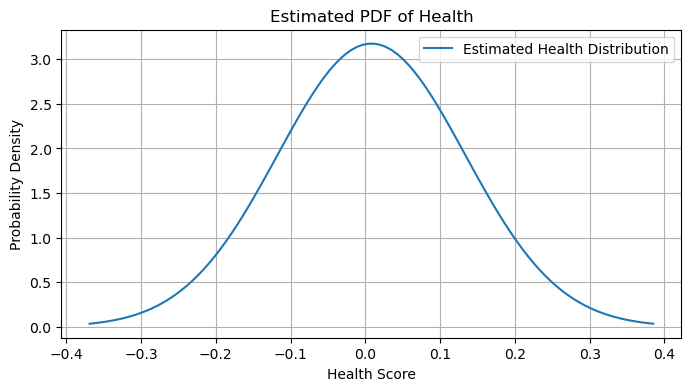

In [15]:
health_values = np.linspace(health_mean - 3*health_stddev, health_mean + 3*health_stddev, 100)

# Calculate the PDF of the estimated distribution
pdf_values = (1 / (health_stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((health_values - health_mean) / health_stddev)**2)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(health_values, pdf_values, label='Estimated Health Distribution')
plt.xlabel('Health Score')
plt.ylabel('Probability Density')
plt.title('Estimated PDF of Health')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt

# Known parameters
exercise_mean = 2  # Example value
exercise_std = 0.5  # Example value
diet_std = 0.5     # Standard deviation for Diet

# Observed diet value
observed_diet = 7  # Example value

with pm.Model() as model:
    # Exercise is a known Gaussian distribution
    exercise = pm.Normal('exercise', mu=exercise_mean, sd=exercise_std)

    # Diet is observed
    diet = pm.Normal('diet', mu=observed_diet, sd=diet_std, observed=observed_diet)

    # Health as a deterministic function of Exercise and Diet
    health_mean = pm.Deterministic('health_mean', 0.3 * exercise + 0.7 * diet)

    # Infer the distribution of Health
    health = pm.Normal('health', mu=health_mean, sd=0.1)  # 0.1 as an initial guess for the standard deviation

    # Perform sampling
    trace = pm.sample(1000, return_inferencedata=True)

# Extracting the posterior distribution for Health
health_samples = trace.posterior['health'].values

# Estimating the mean and standard deviation of Health given Diet
health_mean_estimated = np.mean(health_samples)
health_std_estimated = np.std(health_samples)

health_mean_estimated, health_std_estimated


AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)